## 1. Intro

- Source: [Zomato Restaurants in India (Kaggle)](https://www.kaggle.com/datasets/rabhar/zomato-restaurants-in-india)
- Other info:
    - Has label for training? Not emphasized, but price range can be used
    - Has numerical columns? Yes, rating, cost for two, etc
    - Has categorical columns? Yes, city, locality, cuisines, etc
- Goal:
    - Create embedding for searching similar restaurants?
    - Cluster restaurants by their characteristics
    - Create an interactive map to show the result

## 2. Import Library

In [1]:
import os
import polars as pl
import numpy as np
import joblib

import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import TargetEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score, homogeneity_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

import torch
import torchinfo
import torchmetrics as tm
from torch import nn, optim
from torch.utils.data import DataLoader

# Mixed correlation matrix (Cramer's V, etc)
from dython.nominal import associations

# Abstraction classes to shorten notebook
import lib.skhelper as skhp
import lib.torchhelper as thp
import lib.model as mdl

In [2]:
pio.renderers.default = 'svg'
pio.templates.default = 'plotly_dark'

torch.set_default_device('cuda')

## 3. Load Dataset

In [3]:
df = pl.read_csv('data/zomato_restaurants_in_India.csv', infer_schema_length = 10000)

# Take only a portion of data for faster visualization and training
# TODO: Use proper sampling method to represent whole population
df = df.sample(10000, shuffle = True, seed = 1234)

df

shape: (10_000, 26)
┌──────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬──────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url       ┆ … ┆ photo_cou ┆ opentable ┆ delivery ┆ takeaway │
│ ---      ┆ ---        ┆ ent        ┆ ---       ┆   ┆ nt        ┆ _support  ┆ ---      ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str       ┆   ┆ ---       ┆ ---       ┆ i64      ┆ i64      │
│          ┆            ┆ str        ┆           ┆   ┆ i64       ┆ f64       ┆          ┆          │
╞══════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪══════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ ['Dessert  ┆ https://w ┆ … ┆ 179       ┆ 0.0       ┆ -1       ┆ -1       │
│          ┆ Cream      ┆ Parlour']  ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆ Parlour    ┆            ┆ .com/ahme ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ dab…      ┆   ┆           ┆           ┆          ┆          │
│ 18732759 ┆ Scotland   ┆ ['Bar']    ┆ https://w ┆ … ┆ 26        ┆ 0.0       ┆ 1        ┆ -1       │
│          ┆ Yard       ┆            ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/pati ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ ala…      ┆   ┆           ┆           ┆          ┆          │
│ 18746670 ┆ Coffee     ┆ ['Café']   ┆ https://w ┆ … ┆ 11        ┆ 0.0       ┆ -1       ┆ -1       │
│          ┆ Culture    ┆            ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/jaba ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ lpu…      ┆   ┆           ┆           ┆          ┆          │
│ 18607123 ┆ La Pino'z  ┆ ['Quick    ┆ https://w ┆ … ┆ 251       ┆ 0.0       ┆ -1       ┆ -1       │
│          ┆ Pizza      ┆ Bites']    ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/ahme ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ dab…      ┆   ┆           ┆           ┆          ┆          │
│ 3001572  ┆ The French ┆ ['Café']   ┆ https://w ┆ … ┆ 648       ┆ 0.0       ┆ 1        ┆ -1       │
│          ┆ Door Cafe  ┆            ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆ & Restaur… ┆            ┆ .com/coim ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ bat…      ┆   ┆           ┆           ┆          ┆          │
│ …        ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …        ┆ …        │
│ 18740090 ┆ Green      ┆ ['Quick    ┆ https://w ┆ … ┆ 6         ┆ 0.0       ┆ 1        ┆ -1       │
│          ┆ Kitchen    ┆ Bites']    ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/vell ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ ore…      ┆   ┆           ┆           ┆          ┆          │
│ 18625420 ┆ Burma      ┆ ['Casual   ┆ https://w ┆ … ┆ 2594      ┆ 0.0       ┆ -1       ┆ -1       │
│          ┆ Burma      ┆ Dining']   ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/bang ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ alo…      ┆   ┆           ┆           ┆          ┆          │
│ 18812652 ┆ KMS Hakkim ┆ ['Casual   ┆ https://w ┆ … ┆ 1         ┆ 0.0       ┆ -1       ┆ -1       │
│          ┆            ┆ Dining']   ┆ ww.zomato ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ .com/tric ┆   ┆           ┆           ┆          ┆          │
│          ┆            ┆            ┆ hy/…      ┆   ┆           ┆           ┆          ┆          │
│ 18732617 ┆ Anandham   ┆ ['Casual   ┆ ht

## 4. Exploratory Data Analysis

Some preprocessings will be needed before we can fully explore the data

These preprocessings are mainly for data cleaning and visualization purpose, there will be separate one for ML model later

### 4.1. Drop Single Value Columns

In [4]:
# https://stackoverflow.com/q/75446886/select-columns-based-on-condition

cols = [
    col.name for col in
    # Null is considered a unique value, so we drop them temporarily
    df.select(pl.col('*').drop_nulls().n_unique() == 1)
    if col.all()
]

print('Dropped columns:', cols)
df = df.select(pl.exclude(cols))

df.head()

Dropped columns: ['country_id', 'currency', 'opentable_support', 'takeaway']


shape: (5, 22)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url        ┆ … ┆ rating_tex ┆ votes ┆ photo_coun ┆ delivery │
│ ---      ┆ ---        ┆ ent        ┆ ---        ┆   ┆ t          ┆ ---   ┆ t          ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str        ┆   ┆ ---        ┆ i64   ┆ ---        ┆ i64      │
│          ┆            ┆ str        ┆            ┆   ┆ str        ┆       ┆ i64        ┆          │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ ['Dessert  ┆ https://ww ┆ … ┆ Very Good  ┆ 554   ┆ 179        ┆ -1       │
│          ┆ Cream      ┆ Parlour']  ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ Parlour    ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18732759 ┆ Scotland   ┆ ['Bar']    ┆ https://ww ┆ … ┆ Good       ┆ 94    ┆ 26         ┆ 1        │
│          ┆ Yard       ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/patiala ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18746670 ┆ Coffee     ┆ ['Café']   ┆ https://ww ┆ … ┆ Good       ┆ 63    ┆ 11         ┆ -1       │
│          ┆ Culture    ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/jabalpu ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18607123 ┆ La Pino'z  ┆ ['Quick    ┆ https://ww ┆ … ┆ Very Good  ┆ 979   ┆ 251        ┆ -1       │
│          ┆ Pizza      ┆ Bites']    ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 3001572  ┆ The French ┆ ['Café']   ┆ https://ww ┆ … ┆ Excellent  ┆ 451   ┆ 648        ┆ 1        │
│          ┆ Door Cafe  ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ & Restaur… ┆            ┆ om/coimbat ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────────┴──────────┘

### 4.2. Drop Similar Columns

In [5]:
df = df.drop([
    # Other similar columns already exist
    'city_id', 'locality_verbose', 'rating_text'
])

### 4.3. Data Type Conversion

In [6]:
# Use "col.str.replace" is for substring replace
# Use "col.replace" is for whole value replace

df = df.with_columns(
    # String list to real list
    pl.col('establishment').str.replace_all("'", '"').str.json_decode(),
    pl.col('highlights').str.replace_all("'", '"').str.json_decode(),
    # Comma separated string to list
    pl.col('cuisines').str.split(', ').cast(pl.List(pl.String)),
    # Integer to string (ordinal category)
    pl.col('price_range').cast(pl.String),
    # Zipcode cleansing (non-integer will be replaced by null)
    pl.col('zipcode').str.replace_many([' ', '-','.0'], '').cast(pl.Int64, strict = False).cast(pl.String),
    # Integer to boolean (strict will auto-cast to target type)
    pl.col('delivery').replace_strict([-1, 1], [False, True], default = False)
)

df.head()

shape: (5, 19)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url        ┆ … ┆ aggregate_ ┆ votes ┆ photo_coun ┆ delivery │
│ ---      ┆ ---        ┆ ent        ┆ ---        ┆   ┆ rating     ┆ ---   ┆ t          ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str        ┆   ┆ ---        ┆ i64   ┆ ---        ┆ bool     │
│          ┆            ┆ list[str]  ┆            ┆   ┆ f64        ┆       ┆ i64        ┆          │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ ["Dessert  ┆ https://ww ┆ … ┆ 4.0        ┆ 554   ┆ 179        ┆ false    │
│          ┆ Cream      ┆ Parlour"]  ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ Parlour    ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18732759 ┆ Scotland   ┆ ["Bar"]    ┆ https://ww ┆ … ┆ 3.8        ┆ 94    ┆ 26         ┆ true     │
│          ┆ Yard       ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/patiala ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18746670 ┆ Coffee     ┆ ["Café"]   ┆ https://ww ┆ … ┆ 3.5        ┆ 63    ┆ 11         ┆ false    │
│          ┆ Culture    ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/jabalpu ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18607123 ┆ La Pino'z  ┆ ["Quick    ┆ https://ww ┆ … ┆ 4.3        ┆ 979   ┆ 251        ┆ false    │
│          ┆ Pizza      ┆ Bites"]    ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 3001572  ┆ The French ┆ ["Café"]   ┆ https://ww ┆ … ┆ 4.7        ┆ 451   ┆ 648        ┆ true     │
│          ┆ Door Cafe  ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ & Restaur… ┆            ┆ om/coimbat ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────────┴──────────┘

In [7]:
for name in df.columns:
    col = df.get_column(name)

    if col.dtype == pl.List(pl.String):
        col_len = col.list.len().max()
        print(f'{name}, max length: {col_len}')

        # Convert list to string if it only has 1 element
        if col_len <= 1:
            df = df.with_columns(
                pl.col(name).list.join("")
            )

    # Refresh column after modification
    col = df.get_column(name)

    # Convert empty string to null
    if col.dtype == pl.String:
        df = df.with_columns(
            pl.col(name).replace("", None)
        )

df.head()

establishment, max length: 1
cuisines, max length: 8
highlights, max length: 40


shape: (5, 19)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url        ┆ … ┆ aggregate_ ┆ votes ┆ photo_coun ┆ delivery │
│ ---      ┆ ---        ┆ ent        ┆ ---        ┆   ┆ rating     ┆ ---   ┆ t          ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str        ┆   ┆ ---        ┆ i64   ┆ ---        ┆ bool     │
│          ┆            ┆ str        ┆            ┆   ┆ f64        ┆       ┆ i64        ┆          │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ Dessert    ┆ https://ww ┆ … ┆ 4.0        ┆ 554   ┆ 179        ┆ false    │
│          ┆ Cream      ┆ Parlour    ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ Parlour    ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18732759 ┆ Scotland   ┆ Bar        ┆ https://ww ┆ … ┆ 3.8        ┆ 94    ┆ 26         ┆ true     │
│          ┆ Yard       ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/patiala ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18746670 ┆ Coffee     ┆ Café       ┆ https://ww ┆ … ┆ 3.5        ┆ 63    ┆ 11         ┆ false    │
│          ┆ Culture    ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/jabalpu ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18607123 ┆ La Pino'z  ┆ Quick      ┆ https://ww ┆ … ┆ 4.3        ┆ 979   ┆ 251        ┆ false    │
│          ┆ Pizza      ┆ Bites      ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 3001572  ┆ The French ┆ Café       ┆ https://ww ┆ … ┆ 4.7        ┆ 451   ┆ 648        ┆ true     │
│          ┆ Door Cafe  ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ & Restaur… ┆            ┆ om/coimbat ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────────┴──────────┘

### 4.4. Drop Null Values

In [8]:
df.null_count()

shape: (1, 19)
┌────────┬──────┬───────────────┬─────┬───┬──────────────────┬───────┬─────────────┬──────────┐
│ res_id ┆ name ┆ establishment ┆ url ┆ … ┆ aggregate_rating ┆ votes ┆ photo_count ┆ delivery │
│ ---    ┆ ---  ┆ ---           ┆ --- ┆   ┆ ---              ┆ ---   ┆ ---         ┆ ---      │
│ u32    ┆ u32  ┆ u32           ┆ u32 ┆   ┆ u32              ┆ u32   ┆ u32         ┆ u32      │
╞════════╪══════╪═══════════════╪═════╪═══╪══════════════════╪═══════╪═════════════╪══════════╡
│ 0      ┆ 0    ┆ 219           ┆ 0   ┆ … ┆ 0                ┆ 0     ┆ 0           ┆ 0        │
└────────┴──────┴───────────────┴─────┴───┴──────────────────┴───────┴─────────────┴──────────┘

Observation:
- `address` only has a few null values so it's safe to drop the affected rows
- `zipcode` column can be dropped entirely since we have `latitude` and `longitude` for precise location, and `city` or `address` for general location 
- `establishment` and `cuisines` are hard to fix and I assume restaurant that doesn't have these values is an unpopular restaurant anyway, so it's not worth to include for clustering
- `timings` while seemed valuable, it's too hard to represent it in a way that can be understood be the model later, especially since some restaurants have more than 1 timings

In [9]:
print(df.shape)

df = df.drop(['zipcode', 'timings'])
df = df.drop_nulls(subset = ['address', 'establishment', 'cuisines'])

print(df.shape)

df.null_count()

(10000, 19)
(9716, 17)


shape: (1, 17)
┌────────┬──────┬───────────────┬─────┬───┬──────────────────┬───────┬─────────────┬──────────┐
│ res_id ┆ name ┆ establishment ┆ url ┆ … ┆ aggregate_rating ┆ votes ┆ photo_count ┆ delivery │
│ ---    ┆ ---  ┆ ---           ┆ --- ┆   ┆ ---              ┆ ---   ┆ ---         ┆ ---      │
│ u32    ┆ u32  ┆ u32           ┆ u32 ┆   ┆ u32              ┆ u32   ┆ u32         ┆ u32      │
╞════════╪══════╪═══════════════╪═════╪═══╪══════════════════╪═══════╪═════════════╪══════════╡
│ 0      ┆ 0    ┆ 0             ┆ 0   ┆ … ┆ 0                ┆ 0     ┆ 0           ┆ 0        │
└────────┴──────┴───────────────┴─────┴───┴──────────────────┴───────┴─────────────┴──────────┘

### 4.5. EDA - Data Distribution

In [10]:
cols_exclude = [
    # Useless for visualization
    'res_id', 'url', 'address', 'latitude', 'longitude'
]

cols = [col for col in df.columns if col not in cols_exclude]

# Check columns that want to be visualized
print(len(cols))
print(cols)
print(df.select(cols).dtypes)

12
['name', 'establishment', 'city', 'locality', 'cuisines', 'average_cost_for_two', 'price_range', 'highlights', 'aggregate_rating', 'votes', 'photo_count', 'delivery']
[String, String, String, String, List(String), Int64, String, List(String), Float64, Int64, Int64, Boolean]


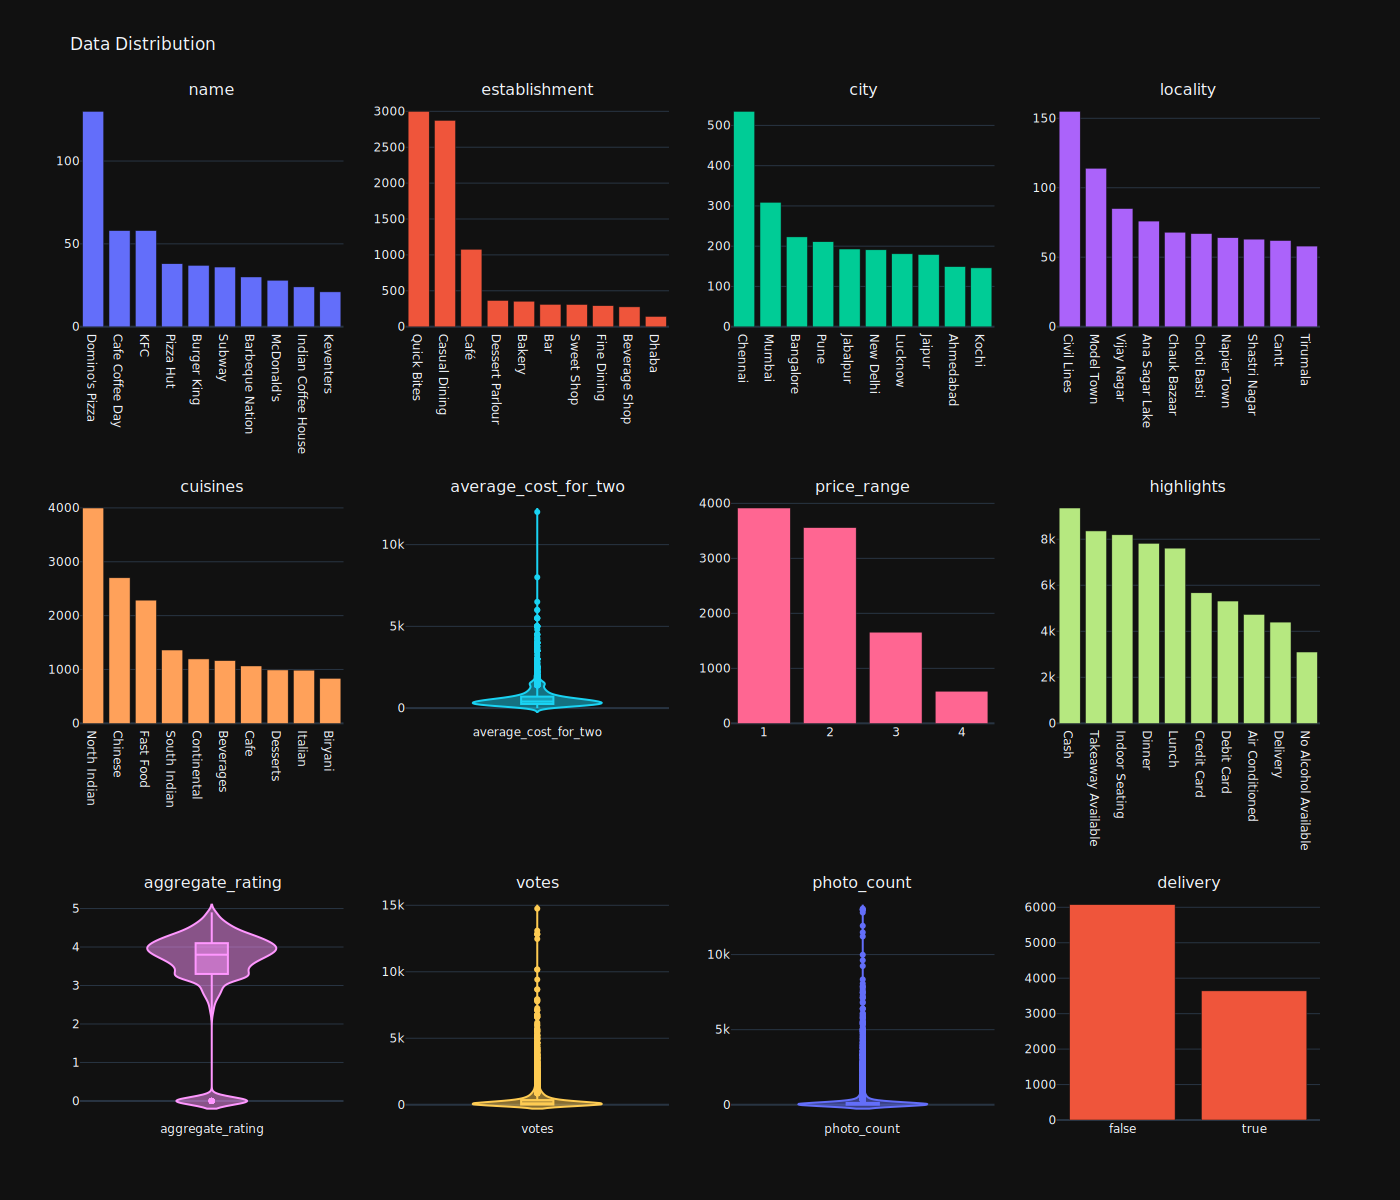

In [11]:
n_rows, n_cols = 3, 4
fig = make_subplots(n_rows, n_cols, subplot_titles = cols)

def top_n_categories(col: pl.Series, top_k = 10):
    # Returns dataframe with 2 columns: value name and value count
    return col.value_counts().top_k(top_k, by = 'count')

for i, name in enumerate(cols):
    irow = i // n_cols + 1
    icol = i % n_cols + 1

    col = df.get_column(name)
    top_k = 10

    if col.dtype in (pl.Int64, pl.Float64):
        fig.add_violin(y = col, box_visible = True, row = irow, col = icol, name = name)
    elif col.dtype in (pl.String, pl.Boolean):
        col = top_n_categories(col, top_k)
        fig.add_bar(x = col[name], y = col['count'], row = irow, col = icol, name = name)
    elif col.dtype == pl.List(pl.String):
        # "list.explode" will combine nested list as one long list
        col = top_n_categories(col.list.explode().drop_nans(), top_k)
        fig.add_bar(x = col[name], y = col['count'], row = irow, col = icol, name = name)

fig.update_layout(title = 'Data Distribution', showlegend = False)
fig.show(width = 1400, height = 1200)

### 4.6. EDA - Correlation Matrix

We will plot the correlation matrix between variables using this formula:
- Continuous-continuous: Spearman's rho (range -1 to 1)
- Nominal-nominal: Cramer's V (range 0 to 1)
- Continuous-nominal or vice versa: Correlation ratio (range 0 to 1)

See starter references:
- https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
- https://www.youtube.com/watch?v=6uu4sFl1avE (Pearson's R vs Spearman's rho)

In [12]:
df.head()

shape: (5, 17)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url        ┆ … ┆ aggregate_ ┆ votes ┆ photo_coun ┆ delivery │
│ ---      ┆ ---        ┆ ent        ┆ ---        ┆   ┆ rating     ┆ ---   ┆ t          ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str        ┆   ┆ ---        ┆ i64   ┆ ---        ┆ bool     │
│          ┆            ┆ str        ┆            ┆   ┆ f64        ┆       ┆ i64        ┆          │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ Dessert    ┆ https://ww ┆ … ┆ 4.0        ┆ 554   ┆ 179        ┆ false    │
│          ┆ Cream      ┆ Parlour    ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ Parlour    ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18732759 ┆ Scotland   ┆ Bar        ┆ https://ww ┆ … ┆ 3.8        ┆ 94    ┆ 26         ┆ true     │
│          ┆ Yard       ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/patiala ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18746670 ┆ Coffee     ┆ Café       ┆ https://ww ┆ … ┆ 3.5        ┆ 63    ┆ 11         ┆ false    │
│          ┆ Culture    ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/jabalpu ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18607123 ┆ La Pino'z  ┆ Quick      ┆ https://ww ┆ … ┆ 4.3        ┆ 979   ┆ 251        ┆ false    │
│          ┆ Pizza      ┆ Bites      ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 3001572  ┆ The French ┆ Café       ┆ https://ww ┆ … ┆ 4.7        ┆ 451   ┆ 648        ┆ true     │
│          ┆ Door Cafe  ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ & Restaur… ┆            ┆ om/coimbat ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────────┴──────────┘

In [13]:
df = df.with_columns(
    # Better represented as other type in correlation matrix
    pl.col('price_range').cast(pl.Int64),
    pl.col('delivery').cast(pl.Int64),
    # Take first value of list to test the correlation
    # First value is probably the most important one
    pl.col('cuisines').list.first().alias('cuisines1'),
    pl.col('highlights').list.first().alias('highlights1')
)

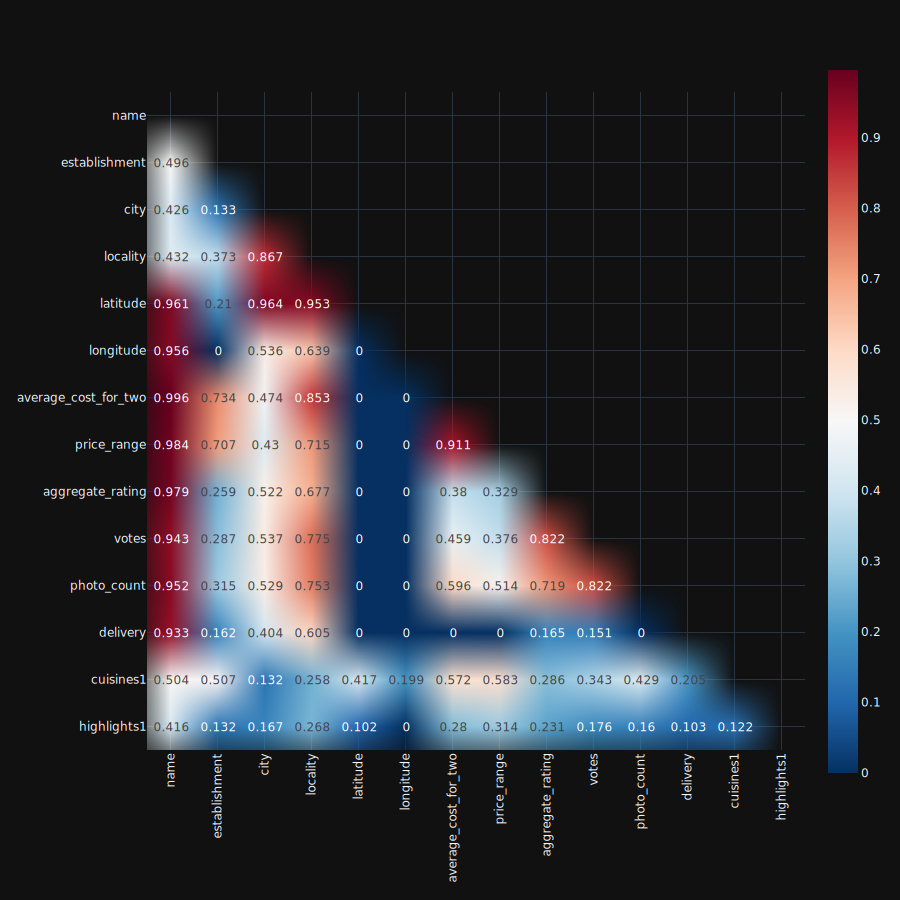

In [14]:
cols_exclude = [
    # Useless for correlation matrix
    'res_id', 'url', 'address',
    # Too complex to correlate since it's a list
    'cuisines', 'highlights'
]

cols = [col for col in df.columns if col not in cols_exclude]
df_tmp = df.select(cols).to_pandas()

corr = associations(
    df_tmp,
    compute_only = True,
    num_num_assoc = 'spearman'
)['corr']

# Values below threshold will be marked as zero
thres = 0.1
corr[(corr > 0) & (corr < thres)] = 0
corr[(corr < 0) & (corr > -thres)] = 0

# Hide the upper triangle since it's the same as bottom triangle
mask = np.triu(np.ones_like(corr, dtype = bool))
corr = corr.mask(mask)

# Limit heatmap precision
corr = corr.round(3)

fig = px.imshow(corr, text_auto = True, color_continuous_scale = 'RdBu_r')
fig.update_layout(xaxis_tickangle = -90)
fig.show(width = 900, height = 900)

Interesting, so there is no column that has inverse relationship with each other (minus value) 

Also, let's make some hypotheses:
- Name is highly correlated with cost and price range, it makes sense since big franchises (KFC, etc) usually have a consistent price for all the restaurants
- Name is also highly correlated with rating, votes, etc which also makes sense since a well established franchise usually has a consistent reputation as well
- Establishment has a pretty good correlation with cost and price range, so probably some establishments (e.g. cafe) across India has more-or-less the same price
- Latitude has a high correlation with city and locality, this probably means that restaurants in each city are consentrated in a narrow latitude but broad longitude
- Delivery is poorly correlated with rating and votes, this means that delivery doesn't affect restaurant popularity
- The first cuisine and highlight doesn't have a sky high correlation with anything. This means that just a single cuisine/highlight can't represent restaurant characteristic
- And so on...

In [15]:
# Drop the temporary columns again since it doesn't mean much
df = df.drop(['cuisines1', 'highlights1'])

### 4.7. EDA - Hypotheses Testing

Let's also check whether some of our previous hypotheses are true or not

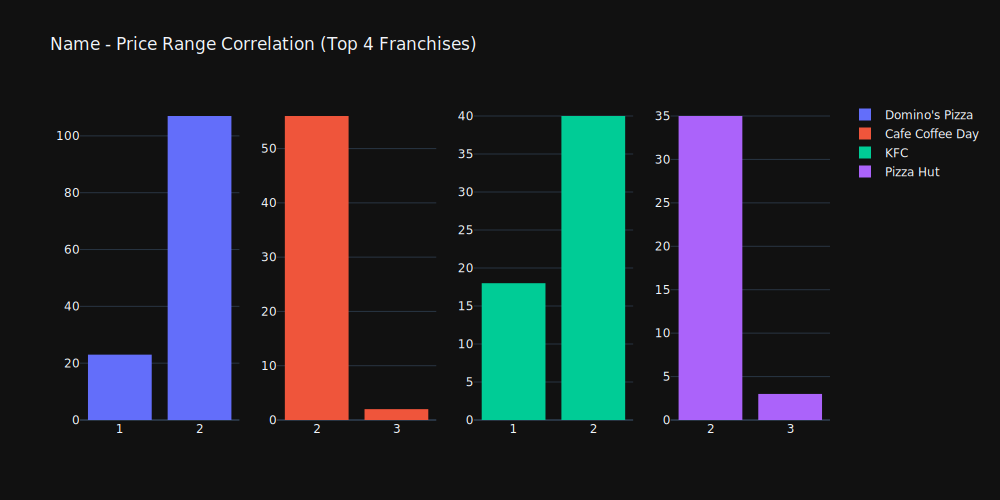

In [16]:
franchise = ['Domino\'s Pizza', 'Cafe Coffee Day', 'KFC', 'Pizza Hut']
fig = make_subplots(rows = 1, cols = len(franchise))

for i, name in enumerate(franchise):
    df_tmp = df.filter(pl.col('name') == name)
    fig.add_histogram(
        x = df_tmp.get_column('price_range').sort().cast(pl.String),
        name = name, row = 1, col = i + 1
    )

fig.update_layout(title = 'Name - Price Range Correlation (Top 4 Franchises)')
fig.show(width = 1000)

From our earlier correlation matrix, restaurant name has a high correlation with price range

We can see that this is true by checking the top restaurant franchises, where the price range for each franchise is pretty consistent across all their restaurants

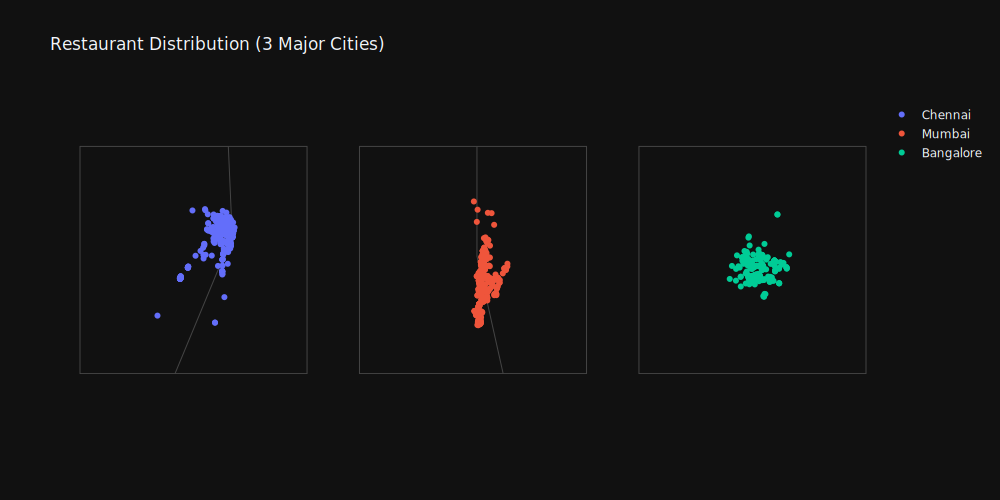

In [17]:
city = ['Chennai', 'Mumbai', 'Bangalore']
lat = [[12.4, 13.4], [18.7, 19.7], [12.5, 13.5]]
lon = [[79.6, 80.6], [72.3, 73.3], [77.1, 78.1]]

df_tmp = df.filter(pl.col('city').is_in(city))

fig = make_subplots(
    rows = 1, cols = len(city),
    specs = [[ {'type': 'scattergeo'} for _ in range(len(city)) ]]
)

for i, name in enumerate(city):
    df_tmp = df.filter(pl.col('city') == name)
    fig.add_scattergeo(
        lat = df_tmp.get_column('latitude'),
        lon = df_tmp.get_column('longitude'),
        row = 1, col = i + 1, name = city[i]
    )

for i, data in enumerate(fig.data):
    fig.layout[data.geo].update(
        lataxis_range = lat[i],
        lonaxis_range = lon[i]
    )

fig.update_layout(title = 'Restaurant Distribution (3 Major Cities)')
fig.show(width = 1000)

From the correlation matrix, city is highly correlated with latitude (the X-axis) but not with longitude (the Y-axis) 

We can also see that this is true, since restaurants on each city (except Bangalore) are more concentrated on X-axis but spread more on the Y-axis

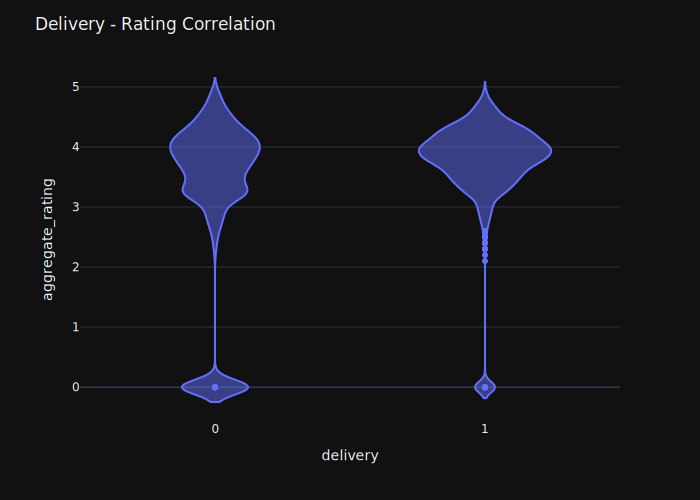

In [18]:
fig = px.violin(df, x = 'delivery', y = 'aggregate_rating')
fig.update_layout(title = 'Delivery - Rating Correlation')
fig.show()

From the correlation matrix, delivery is poorly correlated with rating and votes

This is also true since for restaurants rating are almost always above 3, whether the restaurant does delivery or not

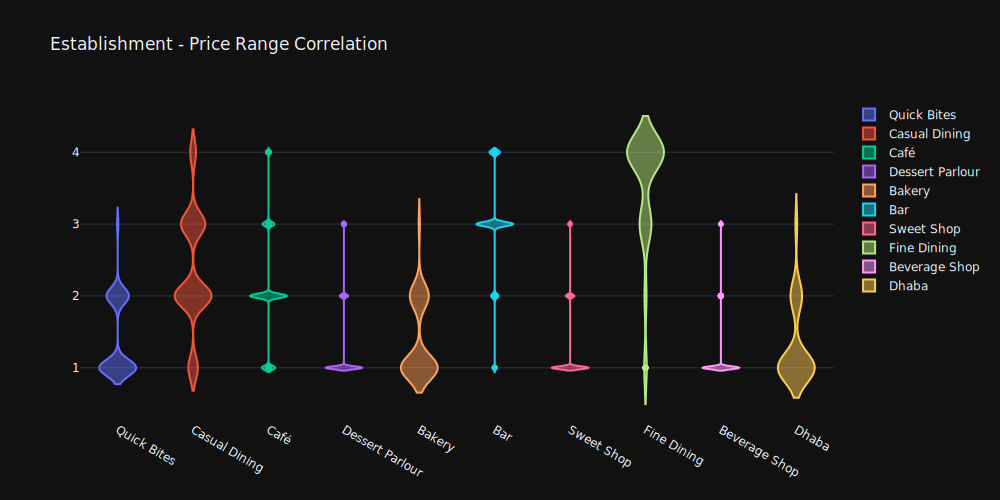

In [19]:
# Get the top 10 establishments only
est = df.get_column('establishment')
est = est.value_counts().top_k(10, by = 'count')[:,0].to_list()

fig = go.Figure()

for name in est:
    df_tmp = df.filter(pl.col('establishment') == name)

    fig.add_violin(
        x = df_tmp.get_column('establishment'),
        y = df_tmp.get_column('price_range'),
        name = name
    )

fig.update_layout(
    title = 'Establishment - Price Range Correlation',
    yaxis_type = 'category', yaxis_categoryorder = 'category ascending'
)

fig.show(width = 1000)

From the correlation matrix, we can see that establishment is highly correlated with price range (albeit not a very strong correlation)

By looking at the visualization above, it's true that each establishment has a common price range but still has some differences, which explains the weaker correlation

And so on... (we don't have time to cross-check all the hypotheses)

In [20]:
# Export clean data in case needed later
# JSON allows nested columns, on CSV it's confusing
df.write_json('data/zomato_clean.json')

## 5. Data Preprocessing

We assume that all the data that passed here are already clean (no null value, etc)

Then we will begin the real data preprocessing for the ML model through pipeline

In [21]:
df.head()

shape: (5, 17)
┌──────────┬────────────┬────────────┬────────────┬───┬────────────┬───────┬────────────┬──────────┐
│ res_id   ┆ name       ┆ establishm ┆ url        ┆ … ┆ aggregate_ ┆ votes ┆ photo_coun ┆ delivery │
│ ---      ┆ ---        ┆ ent        ┆ ---        ┆   ┆ rating     ┆ ---   ┆ t          ┆ ---      │
│ i64      ┆ str        ┆ ---        ┆ str        ┆   ┆ ---        ┆ i64   ┆ ---        ┆ i64      │
│          ┆            ┆ str        ┆            ┆   ┆ f64        ┆       ┆ i64        ┆          │
╞══════════╪════════════╪════════════╪════════════╪═══╪════════════╪═══════╪════════════╪══════════╡
│ 112520   ┆ Trupti Ice ┆ Dessert    ┆ https://ww ┆ … ┆ 4.0        ┆ 554   ┆ 179        ┆ 0        │
│          ┆ Cream      ┆ Parlour    ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ Parlour    ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18732759 ┆ Scotland   ┆ Bar        ┆ https://ww ┆ … ┆ 3.8        ┆ 94    ┆ 26         ┆ 1        │
│          ┆ Yard       ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/patiala ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18746670 ┆ Coffee     ┆ Café       ┆ https://ww ┆ … ┆ 3.5        ┆ 63    ┆ 11         ┆ 0        │
│          ┆ Culture    ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/jabalpu ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 18607123 ┆ La Pino'z  ┆ Quick      ┆ https://ww ┆ … ┆ 4.3        ┆ 979   ┆ 251        ┆ 0        │
│          ┆ Pizza      ┆ Bites      ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ om/ahmedab ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
│ 3001572  ┆ The French ┆ Café       ┆ https://ww ┆ … ┆ 4.7        ┆ 451   ┆ 648        ┆ 1        │
│          ┆ Door Cafe  ┆            ┆ w.zomato.c ┆   ┆            ┆       ┆            ┆          │
│          ┆ & Restaur… ┆            ┆ om/coimbat ┆   ┆            ┆       ┆            ┆          │
│          ┆            ┆            ┆ …          ┆   ┆            ┆       ┆            ┆          │
└──────────┴────────────┴────────────┴────────────┴───┴────────────┴───────┴────────────┴──────────┘

### 5.1. Preprocessing Pipeline

Drop columns, encode categorical features, scale feature ranges, etc

In [22]:
cols_exclude = [
    # Useless for clustering
    'res_id', 'url', 'address',
    # Target class for text embedding
    'price_range'
]

pipe1 = ColumnTransformer(
    [
        (
            'category_encoder',
            TargetEncoder(),
            skhp.ColumnSelector(
                pl.col(pl.String).exclude(cols_exclude)
            )
        ),
        (
            'list_to_string',
            skhp.ListJoiner(join_all_cols = True),
            skhp.ColumnSelector(
                pl.col(pl.List(pl.String)).exclude(cols_exclude)
            )
        ),
        (
            'column_dropper',
            'drop',
            skhp.ColumnSelector(
                # Exclude price_range from the previous preprocessings
                # But don't actually drop the price_range column
                pl.col(cols_exclude).exclude('price_range')
            )
        ),
        (
            'one_hot_encoder',
            OneHotEncoder(sparse_output = False),
            ['price_range']
        )
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

# Set output to Polars for easier previewing
# The default one will be numpy array
pipe1.set_output(transform = 'polars')

# Pass a test data and check the result
temp = pipe1.fit_transform(
    X = df,
    y = df.get_column('price_range')
)

temp.head()

shape: (5, 28)
┌──────────┬──────────┬──────────┬──────────┬───┬─────────────────┬───────┬─────────────┬──────────┐
│ name_1   ┆ name_2   ┆ name_3   ┆ name_4   ┆ … ┆ aggregate_ratin ┆ votes ┆ photo_count ┆ delivery │
│ ---      ┆ ---      ┆ ---      ┆ ---      ┆   ┆ g               ┆ ---   ┆ ---         ┆ ---      │
│ f64      ┆ f64      ┆ f64      ┆ f64      ┆   ┆ ---             ┆ i64   ┆ i64         ┆ i64      │
│          ┆          ┆          ┆          ┆   ┆ f64             ┆       ┆             ┆          │
╞══════════╪══════════╪══════════╪══════════╪═══╪═════════════════╪═══════╪═════════════╪══════════╡
│ 0.403062 ┆ 0.366268 ┆ 0.170591 ┆ 0.06008  ┆ … ┆ 4.0             ┆ 554   ┆ 179         ┆ 0        │
│ 0.403062 ┆ 0.366139 ┆ 0.170591 ┆ 0.060208 ┆ … ┆ 3.8             ┆ 94    ┆ 26          ┆ 1        │
│ 0.0      ┆ 0.420411 ┆ 0.491964 ┆ 0.0      ┆ … ┆ 3.5             ┆ 63    ┆ 11          ┆ 0        │
│ 0.0      ┆ 0.846691 ┆ 0.129017 ┆ 0.0      ┆ … ┆ 4.3             ┆ 979   ┆ 251         ┆ 0        │
│ 0.0      ┆ 0.0      ┆ 0.0      ┆ 1.0      ┆ … ┆ 4.7             ┆ 451   ┆ 648         ┆ 1        │
└──────────┴──────────┴──────────┴──────────┴───┴─────────────────┴───────┴─────────────┴──────────┘

In [23]:
# We need to 2 separate column transformers since the previous changes
# (e.g. the newly added columns) won't be known immediately by the next
# steps in the same transformer

pipe2 = ColumnTransformer(
    [
        (
            'std_scaler',
            StandardScaler(),
            skhp.ColumnSelector(
                pl.exclude([
                    r'^price_range_\d+$',
                    'cuisines_highlights'
                ]),
            )
        ),
        (
            'sentence_to_idx',
            skhp.SentenceToIndex(
                max_vocab = 1000,
                max_words = 50,
                # Pad with zero
                padding = 'start',
                unnest = True
            ),
            skhp.ColumnSelector(
                pl.col('cuisines_highlights')
            )
        )
    ],
    remainder = 'passthrough',
    verbose_feature_names_out = False
)

pipe2.set_output(transform = 'polars')
temp = pipe2.fit_transform(X = temp)

temp.head()

shape: (5, 77)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ name_1    ┆ name_2    ┆ name_3    ┆ name_4    ┆ … ┆ price_ran ┆ price_ran ┆ price_ran ┆ price_ra │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ge_1      ┆ ge_2      ┆ ge_3      ┆ nge_4    │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0.0839    ┆ -0.092561 ┆ 0.003857  ┆ 0.049474  ┆ … ┆ 1.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ 0.0839    ┆ -0.093    ┆ 0.003857  ┆ 0.050515  ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 0.0      │
│ -1.331888 ┆ 0.092086  ┆ 1.438823  ┆ -0.437083 ┆ … ┆ 0.0       ┆ 0.0       ┆ 1.0       ┆ 0.0      │
│ -1.331888 ┆ 1.545856  ┆ -0.181773 ┆ -0.437083 ┆ … ┆ 0.0       ┆ 1.0       ┆ 0.0       ┆ 0.0      │
│ -1.331888 ┆ -1.341668 ┆ -0.757848 ┆ 7.661434  ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 1.0      │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Define the real pipeline here, which combines the two previous transformers

Pipeline output SHOULD NOT replace the original dataframe! This will avoid so much headache later on (during evaluation phase)

We only call pipeline to pass the output to a model, leaving the the original data untouched

In [24]:
model_preproc_file = 'data/model/preproc_pipeline.pkl'

pipeline = Pipeline([
    ('pipe1', pipe1),
    ('pipe2', pipe2)
])

pipeline.set_output(transform = 'polars')
del temp

# Save the pipeline to file
with open(model_preproc_file, 'wb') as f:
    joblib.dump(pipeline, f, protocol = 5)

### 5.2. Train-Validation Split

In [25]:
train_df, val_df = train_test_split(
    df,
    train_size = 0.8,
    random_state = 1337,
    shuffle = True
)

print(train_df.shape)
print(val_df.shape)

# # Delete the original
# del df

(7772, 17)
(1944, 17)


### 5.3. Text Embedding

Cuisines and highlights (the text features) need to be transformed in a way that can be understood by ML model, that is, via embedding

Unlike one-hot encoding, embedding can handle non-uniform sentence length and unknown value (e.g. new cuisine name) just fine

This section is inspired by this [reference](https://web.archive.org/web/20240418150213/http://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/) (where he combined embedding process and other features in 1 model)

In [26]:
train_ds = mdl.MixedDataset(
    pipeline.fit_transform(
        train_df,
        train_df.get_column('price_range')
    ),
    pl.col(r'^cuisines_highlights_\d+$'),
    pl.col(r'^price_range_\d+$')
)

val_ds = mdl.MixedDataset(
    # Validation data shouldn't be fitted
    pipeline.transform(val_df),
    pl.col(r'^cuisines_highlights_\d+$'),
    pl.col(r'^price_range_\d+$')
)

# # Delete the original
# del train_df
# del val_df

Embedding needs a purpose (target), since we don't have one, I decided to use price range as a workaround

Hopefully it can detect which cuisines or highlights that are cheaper or more expensive than the others, resulting in better cluster later

EDIT: I have compared price range and average cost for two, price range resulted in better silhoutte score later

In [27]:
# Text features
print(train_ds[:]['text'].shape)
# Other features
print(train_ds[:]['other'].shape)
# Target classes
print(train_ds[:]['target'].shape)

torch.Size([7772, 50])
torch.Size([7772, 23])
torch.Size([7772, 4])


In [28]:
model = mdl.TextEmbedding(
    embedding_vocab = 1000,
    embedding_dim = 100,
    # Input shape of the features
    text_features = 50,
    other_features = 23,
    # There are only 4 possible price range
    target_classes = 4
)

print('Model parameters:')
thp.parameters(model)

torchinfo.summary(
    model,
    row_settings = ['var_names'],
    col_names = ['input_size', 'output_size', 'num_params', 'trainable'],
    # Input must always be 2D, even if we only pass 1 row
    input_data = [ train_ds[0:1]['text'], train_ds[0:1]['other'] ]
)

Model parameters:
┌─────────────────────────┬──────────────┬─────────────┬───────────────┐
│ param                   ┆ layer        ┆ param_shape ┆ param_type    │
╞═════════════════════════╪══════════════╪═════════════╪═══════════════╡
│ text_input.0.weight     ┆ EmbeddingBag ┆ [1000, 100] ┆ torch.float32 │
│ text_input.1.weight     ┆ Linear       ┆ [128, 100]  ┆ torch.float32 │
│ text_input.1.bias       ┆ Linear       ┆ [128]       ┆ torch.float32 │
│ other_input.weight      ┆ Linear       ┆ [128, 23]   ┆ torch.float32 │
│ other_input.bias        ┆ Linear       ┆ [128]       ┆ torch.float32 │
│ combined_input.1.weight ┆ BatchNorm1d  ┆ [256]       ┆ torch.float32 │
│ combined_input.1.bias   ┆ BatchNorm1d  ┆ [256]       ┆ torch.float32 │
│ combined_input.2.weight ┆ Linear       ┆ [4, 256]    ┆ torch.float32 │
│ combined_input.2.bias   ┆ Linear       ┆ [4]         ┆ torch.float32 │
└─────────────────────────┴──────────────┴─────────────┴───────────────┘


Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
TextEmbedding (TextEmbedding)            [1, 50]                   [1, 4]                    --                        True
├─Sequential (text_input)                [1, 50]                   [1, 128]                  --                        True
│    └─EmbeddingBag (0)                  [1, 50]                   [1, 100]                  100,000                   True
│    └─Linear (1)                        [1, 100]                  [1, 128]                  12,928                    True
├─Linear (other_input)                   [1, 23]                   [1, 128]                  3,072                     True
├─Sequential (combined_input)            [1, 256]                  [1, 4]                    --                        True
│    └─ReLU (0)                          [1, 256]                  [1, 256]                  --                        --
│    

In [29]:
# Load previous training weight and history if exist
model_weight_file = 'data/model/embedding_weight.pth'
model_history_file = 'data/model/embedding_history.json'

if os.path.isfile(model_weight_file):
    model.load_state_dict(
        torch.load(
            model_weight_file,
            weights_only = True
        )
    )

    # Always set to eval mode when not training
    # To prevent accidental weight update when calling model
    model.eval()

logger = thp.SimpleLogger()

if os.path.isfile(model_history_file):
    logger.from_json(model_history_file)

Don't execute the next cell if you don't want to train again!

In [ ]:
# # Reset parameters before each training
# model.reset_parameters()

lr = 0.001
max_epoch = 30
batch_size = 100

train_loader = DataLoader(dataset = train_ds, batch_size = batch_size)
val_loader = DataLoader(dataset = val_ds, batch_size = batch_size)

optimizer = optim.Adam(model.parameters(), lr = lr)
# CrossEntropyLoss = LogSoftmax + NLLLoss
# So there is no need for softmax layer on the model
criterion = nn.CrossEntropyLoss()
# Use multi-label if the class is one-hot encoded
# Which may be required for cross entropy loss
metric = tm.Accuracy(task = 'multilabel', num_labels = 4)

def train_step():
    model.train()

    for i, batch in enumerate(train_loader):
        target = batch['target']
        pred = model(batch['text'], batch['other'])

        loss = criterion(pred, target)
        acc = metric(torch.softmax(pred, dim = 1), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        logger.log('train_loss__', loss.item())
        print(f'[TRAIN] Epoch {epoch + 1} Batch {i + 1}: Loss = {loss} Acc = {acc}')

    # Compute the mean accuracy for whole epoch based on previous calls
    # torchmetrics library can do it automatically, no need for logger
    acc = metric.compute()
    metric.reset()

    # Compute the mean loss (manually, by using my custom logger)
    loss = logger.mean('train_loss__', result_to = 'train_loss')
    logger.log('train_acc', acc.item())

    print(f'[TRAIN] End of epoch {epoch + 1}: Avg Loss = {loss} Avg Acc = {acc}')

def val_step():
    model.eval()

    for batch in val_loader:
        target = batch['target']
        pred = model(batch['text'], batch['other'])

        loss = criterion(pred, target)
        acc = metric(torch.softmax(pred, dim = 1), target)

        logger.log('val_loss__', loss.item())

    acc = metric.compute()
    metric.reset()

    loss = logger.mean('val_loss__', result_to = 'val_loss')
    logger.log('val_acc', acc.item())

    print(f'[EVAL] End of epoch {epoch + 1}: Avg Loss = {loss} Avg Acc = {acc}')

# Start the actual training
for epoch in range(max_epoch):
    train_step()
    val_step()

    if logger.max('val_acc') == logger.last('val_acc'):
        print(f'Saving model checkpoint to "{model_weight_file}"')
        torch.save(model.state_dict(), model_weight_file)

# Set to eval mode after training
# Must be done to prevent accidental weight update!
model.eval()
# Save model training history
logger.to_json(model_history_file)

[TRAIN] Epoch 1 Batch 1: Loss = 1.4112597703933716 Acc = 0.7174999713897705
[TRAIN] Epoch 1 Batch 2: Loss = 1.302531361579895 Acc = 0.7475000023841858
[TRAIN] Epoch 1 Batch 3: Loss = 1.2414699792861938 Acc = 0.7699999809265137
[TRAIN] Epoch 1 Batch 4: Loss = 1.1474583148956299 Acc = 0.7825000286102295
[TRAIN] Epoch 1 Batch 5: Loss = 1.049721598625183 Acc = 0.7825000286102295
[TRAIN] Epoch 1 Batch 6: Loss = 1.0790754556655884 Acc = 0.7799999713897705
[TRAIN] Epoch 1 Batch 7: Loss = 0.9638474583625793 Acc = 0.8125
[TRAIN] Epoch 1 Batch 8: Loss = 0.8849033713340759 Acc = 0.8199999928474426
[TRAIN] Epoch 1 Batch 9: Loss = 0.8830837607383728 Acc = 0.8374999761581421
[TRAIN] Epoch 1 Batch 10: Loss = 0.9205443263053894 Acc = 0.8324999809265137
[TRAIN] Epoch 1 Batch 11: Loss = 0.8849074244499207 Acc = 0.8324999809265137
[TRAIN] Epoch 1 Batch 12: Loss = 0.7373583912849426 Acc = 0.862500011920929
[TRAIN] Epoch 1 Batch 13: Loss = 0.8901054263114929 Acc = 0.8299999833106995
[TRAIN] Epoch 1 Batch 1

Embedding will transform the text (cuisines and highlights) into numeric features

This is required because most (if not all) clustering algorithms can only process numeric features

In [30]:
def preproc_for_clustering(df):
    # Preprocess the dataframe since we will use it for clustering
    # But backup price_range column (we don't need it one-hot encoded)
    price_col = df.get_column('price_range')
    df = pipeline.transform(df)

    # Transform dataframe to tensor
    ds = mdl.MixedDataset(
        df,
        pl.col(r'^cuisines_highlights_\d+$'),
        pl.col(r'^price_range_\d+$')
    )

    # Take the output of embedding layer only from the model
    # The output will represent cuisines and highlights column
    emb_model = thp.OutputHook(model, 'text_input.0', to_numpy = True)

    # Convert the embedding output back as dataframe
    # The output will have 100 dimensions (columns)
    emb_output =  pl.DataFrame(
        emb_model(ds[:]['text'], ds[:]['other']),
        schema = [ f'cuisines_highlights_{i}' for i in range(100) ]
    )

    # Drop the columns that we will replace
    df = df.drop(
        r'^cuisines_highlights_\d+$',
        r'^price_range_\d+$'
    )

    return pl.concat(
        [df, price_col.to_frame(), emb_output],
        how = 'horizontal'
    )

# We don't need validation data for clustering
clust_df = preproc_for_clustering(df)
clust_df.head()

shape: (5, 124)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ name_1    ┆ name_2    ┆ name_3    ┆ name_4    ┆ … ┆ cuisines_ ┆ cuisines_ ┆ cuisines_ ┆ cuisines │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ highlight ┆ highlight ┆ highlight ┆ _highlig │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ s_96      ┆ s_97      ┆ s_98      ┆ hts_99   │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f32       ┆ f32       ┆ f32       ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2.290748  ┆ -1.388314 ┆ -0.798266 ┆ -0.453175 ┆ … ┆ -0.493676 ┆ -0.104411 ┆ -0.151256 ┆ -0.10328 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ -1.392308 ┆ -1.388314 ┆ 3.838513  ┆ -0.453175 ┆ … ┆ 0.029758  ┆ -0.084895 ┆ -0.051879 ┆ -0.24107 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 8        │
│ -1.392308 ┆ 0.022014  ┆ 1.701308  ┆ -0.453175 ┆ … ┆ 0.020674  ┆ -0.110939 ┆ -0.145076 ┆ -0.21193 │
│ -1.392308 ┆ 1.688257  ┆ -0.262362 ┆ -0.453175 ┆ … ┆ -0.010718 ┆ -0.23445  ┆ -0.184897 ┆ -0.14453 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 3        │
│ -1.392308 ┆ -1.388314 ┆ -0.798266 ┆ 7.668019  ┆ … ┆ -0.084956 ┆ -0.361729 ┆ -0.090095 ┆ -0.19297 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

The resulting dataframe then can be passed to clustering model later, since all features has become numeric

Note that we didn't replace the original `train_df` and `val_df`, they should always stay untouched (untransformed)

## 6. Clustering

### 6.1. Build Clustering Model

In [31]:
kmeans = MiniBatchKMeans(n_clusters = 4, random_state = 1234)

# Test the model and save the result as dataframe
temp = kmeans.fit_predict(clust_df)
temp = pl.DataFrame(temp, schema = ['cluster'])
# Append the cluster result to original dataframe
temp = pl.concat([clust_df, temp], how = 'horizontal')

temp.head()

shape: (5, 125)
┌───────────┬───────────┬───────────┬───────────┬───┬────────────┬───────────┬───────────┬─────────┐
│ name_1    ┆ name_2    ┆ name_3    ┆ name_4    ┆ … ┆ cuisines_h ┆ cuisines_ ┆ cuisines_ ┆ cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ighlights_ ┆ highlight ┆ highlight ┆ ---     │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ 97         ┆ s_98      ┆ s_99      ┆ i32     │
│           ┆           ┆           ┆           ┆   ┆ ---        ┆ ---       ┆ ---       ┆         │
│           ┆           ┆           ┆           ┆   ┆ f32        ┆ f32       ┆ f32       ┆         │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═════════╡
│ 2.290748  ┆ -1.388314 ┆ -0.798266 ┆ -0.453175 ┆ … ┆ -0.104411  ┆ -0.151256 ┆ -0.103282 ┆ 0       │
│ -1.392308 ┆ -1.388314 ┆ 3.838513  ┆ -0.453175 ┆ … ┆ -0.084895  ┆ -0.051879 ┆ -0.241078 ┆ 1       │
│ -1.392308 ┆ 0.022014  ┆ 1.701308  ┆ -0.453175 ┆ … ┆ -0.110939  ┆ -0.145076 ┆ -0.21193  ┆ 3       │
│ -1.392308 ┆ 1.688257  ┆ -0.262362 ┆ -0.453175 ┆ … ┆ -0.23445   ┆ -0.184897 ┆ -0.144533 ┆ 3       │
│ -1.392308 ┆ -1.388314 ┆ -0.798266 ┆ 7.668019  ┆ … ┆ -0.361729  ┆ -0.090095 ┆ -0.19297  ┆ 2       │
└───────────┴───────────┴───────────┴───────────┴───┴────────────┴───────────┴───────────┴─────────┘

Good, let's test the optimal number of clusters before we proceed further

### 6.2. Cluster Evaluation

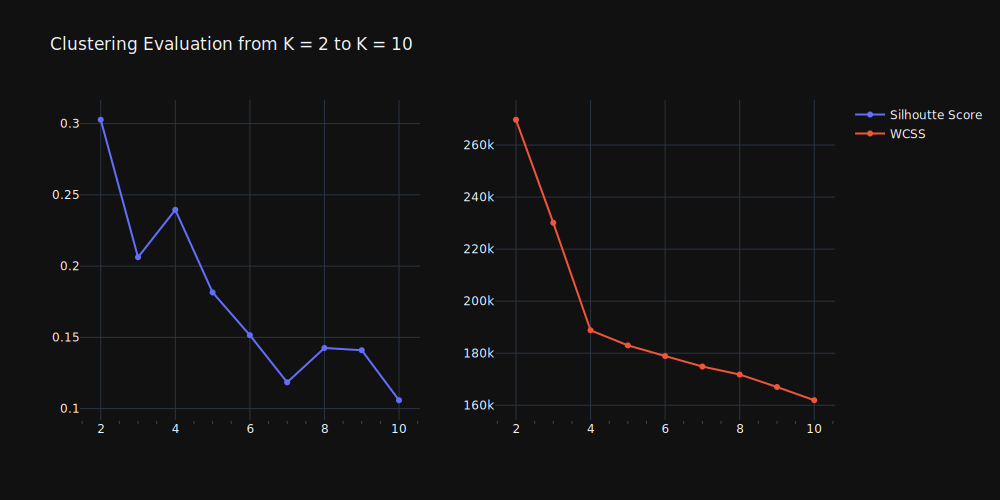

In [32]:
silhoutte = []
wcss = []

for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters = k, random_state = 1234)

    s = silhouette_score(
        clust_df,
        kmeans.fit_predict(clust_df)
    )

    silhoutte.append(s)
    wcss.append(kmeans.inertia_)

fig = make_subplots(rows = 1, cols = 2)

fig.add_traces(
    [
        go.Scatter(
            x = [ k for k in range(2, 11) ],
            y = silhoutte,
            name = 'Silhoutte Score'
        ),
        go.Scatter(
            x = [ k for k in range(2, 11) ],
            y = wcss,
            name = 'WCSS'
        )
    ],
    rows = [1, 1],
    cols = [1, 2]
)

fig.update_xaxes(minor_ticks = 'outside')
fig.update_layout(title = 'Clustering Evaluation from K = 2 to K = 10')

fig.show(width = 1000)

Seems like 4 clusters are the best, although the silhoutte score is not the best (0.5 or above is considered good)

### 6.3. Feature Selection

Let's try removing less important features and see if we can improve the score a bit

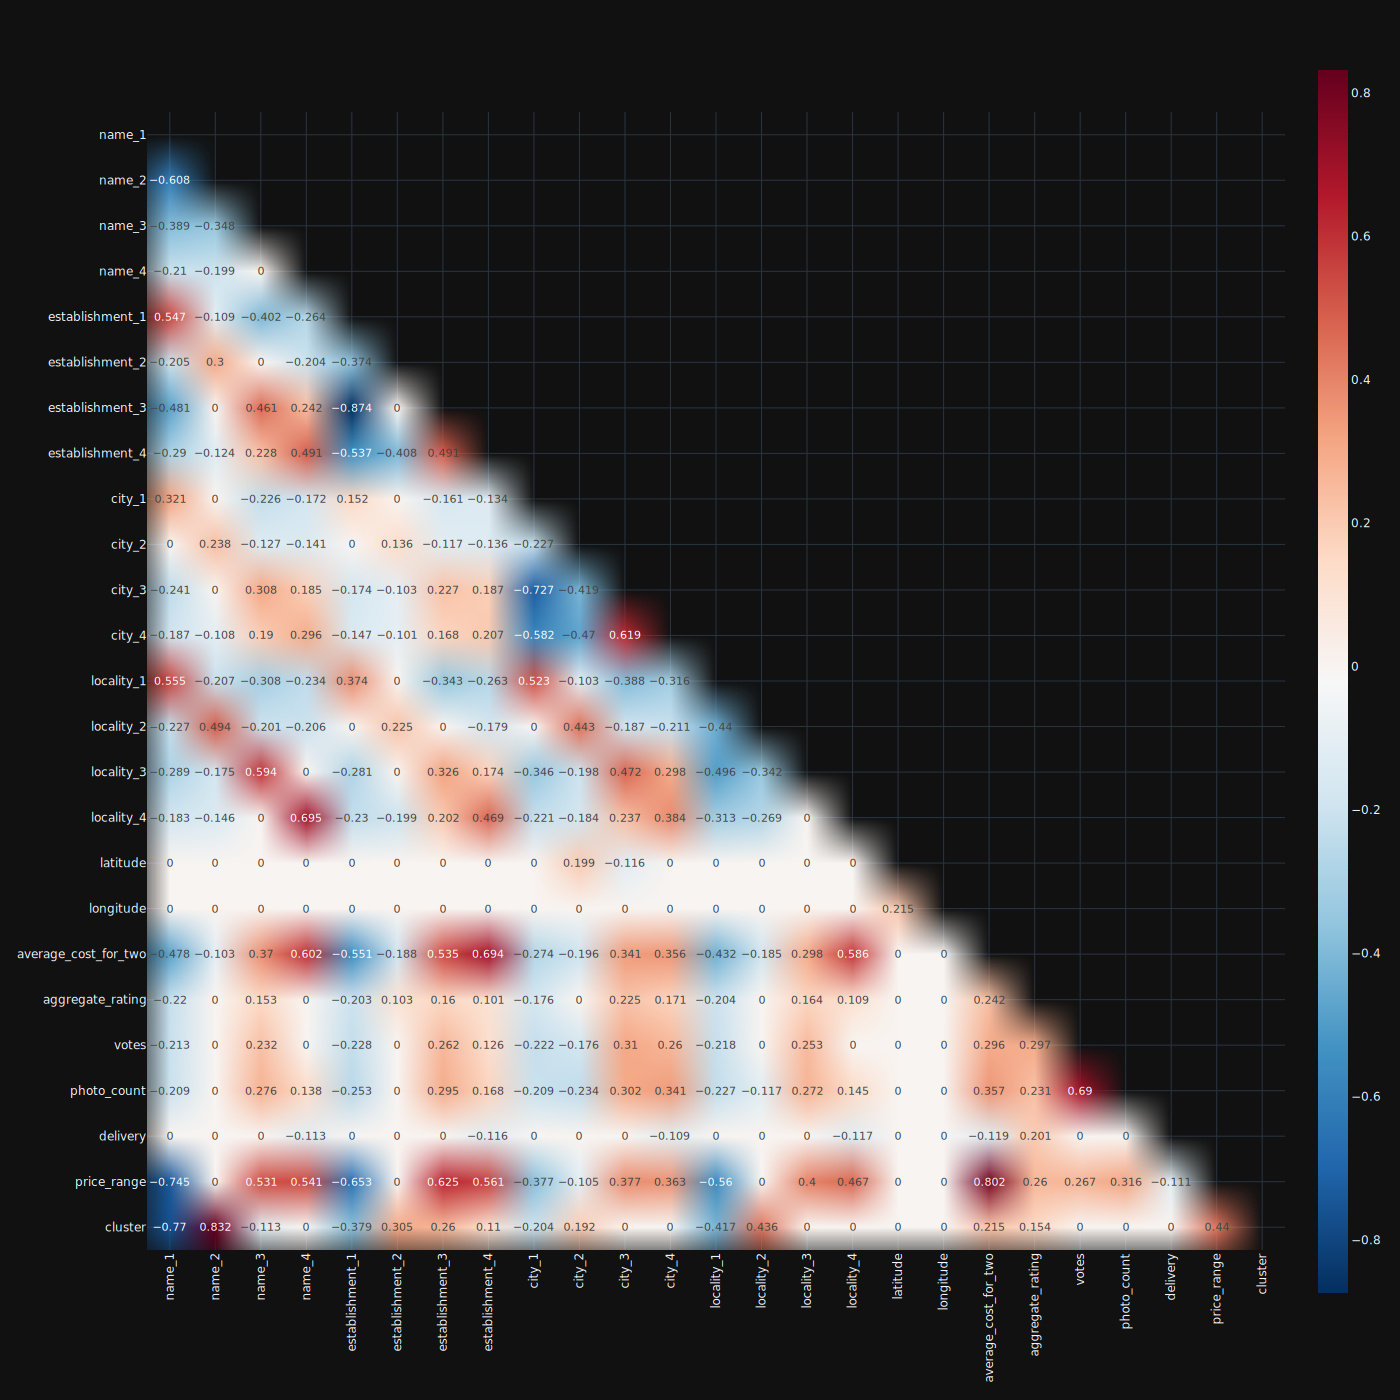

In [33]:
# Exclude embedding columns from the correlation matrix
# Because we can't remove just one or two embedding columns anyway
# It's either removing the whole embedding columns or let them stay
temp = temp.with_columns(
    pl.col(pl.List(pl.String)).list.join(" ")
).drop(pl.col(r'^cuisines_highlights_\d+$'))

corr = associations(
    temp.to_pandas(),
    compute_only = True
)['corr']

# Values below threshold will be marked as zero
thres = 0.1
corr[(corr > 0) & (corr < thres)] = 0
corr[(corr < 0) & (corr > -thres)] = 0

# Hide the upper triangle since it's the same as bottom triangle
mask = np.triu(np.ones_like(corr, dtype = bool))
corr = corr.mask(mask)

# Limit heatmap precision
corr = corr.round(3)

fig = px.imshow(corr, text_auto = True, color_continuous_scale = 'RdBu_r')
fig.update_layout(xaxis_tickangle = -90)
fig.show(width = 1400, height = 1400)

The cluster result (last row) seems heavily depend on the name, locality (local area), and price range

City seems to have similar effect as locality, but not as strong, so we can just drop it

Other columns we can also drop:
- Latitude and longitude
- Votes, photo count, and delivery
- Price range (to see how well the clustering will perform without it)

In [34]:
temp = clust_df.drop(
    r'^city_\d+$', 'latitude', 'longitude',
    'votes', 'photo_count', 'delivery',
    'price_range'
)

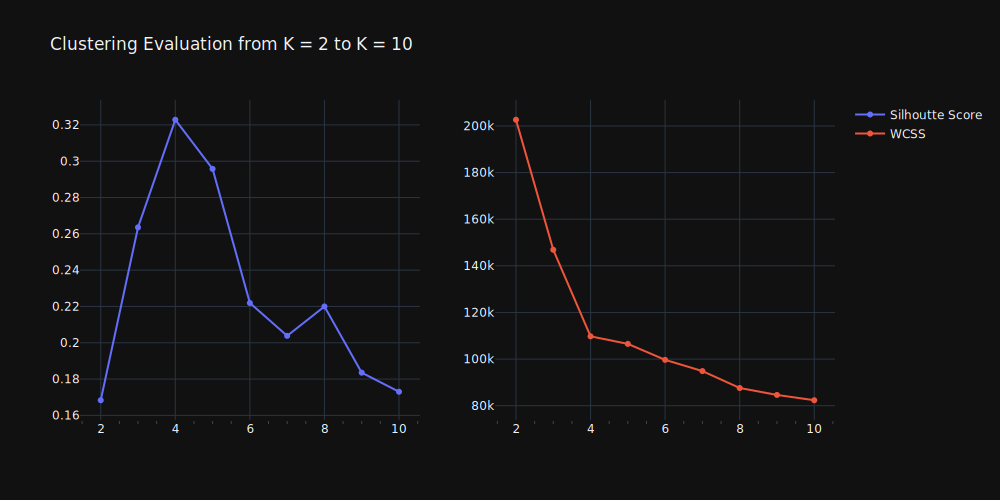

In [35]:
silhoutte = []
wcss = []

for k in range(2, 11):
    kmeans = MiniBatchKMeans(n_clusters = k, random_state = 1234)

    s = silhouette_score(
        temp,
        kmeans.fit_predict(temp)
    )

    silhoutte.append(s)
    wcss.append(kmeans.inertia_)

fig = make_subplots(rows = 1, cols = 2)

fig.add_traces(
    [
        go.Scatter(
            x = [ k for k in range(2, 11) ],
            y = silhoutte,
            name = 'Silhoutte Score'
        ),
        go.Scatter(
            x = [ k for k in range(2, 11) ],
            y = wcss,
            name = 'WCSS'
        )
    ],
    rows = [1, 1],
    cols = [1, 2]
)

fig.update_xaxes(minor_ticks = 'outside')
fig.update_layout(title = 'Clustering Evaluation from K = 2 to K = 10')

fig.show(width = 1000)

The silhoutte score improved by 9% (from 0.24 to 0.33), though I suspect lesser features will always result higher score

Anyway, I think we shouldn't remove more features blindly just to improve this score

It may be misleading (better score != better cluster), since we also lost information by dropping columns

### 6.4. Cluster Visualization

Finalize the result first (not as temporary variable)

In [36]:
clust_df = clust_df.drop(
    r'^city_\d+$', 'latitude', 'longitude',
    'votes', 'photo_count', 'delivery',
    'price_range'
)

kmeans = MiniBatchKMeans(n_clusters = 4, random_state = 1337)

temp = kmeans.fit_predict(clust_df)
temp = pl.DataFrame(temp, schema = ['cluster'])
clust_df = pl.concat([clust_df, temp], how = 'horizontal')

# Also add the cluster result to original dataframe
df = pl.concat([df, temp], how = 'horizontal')

clust_df.head()

shape: (5, 115)
┌───────────┬───────────┬───────────┬───────────┬───┬────────────┬───────────┬───────────┬─────────┐
│ name_1    ┆ name_2    ┆ name_3    ┆ name_4    ┆ … ┆ cuisines_h ┆ cuisines_ ┆ cuisines_ ┆ cluster │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ighlights_ ┆ highlight ┆ highlight ┆ ---     │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ 97         ┆ s_98      ┆ s_99      ┆ i32     │
│           ┆           ┆           ┆           ┆   ┆ ---        ┆ ---       ┆ ---       ┆         │
│           ┆           ┆           ┆           ┆   ┆ f32        ┆ f32       ┆ f32       ┆         │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪════════════╪═══════════╪═══════════╪═════════╡
│ 2.290748  ┆ -1.388314 ┆ -0.798266 ┆ -0.453175 ┆ … ┆ -0.104411  ┆ -0.151256 ┆ -0.103282 ┆ 0       │
│ -1.392308 ┆ -1.388314 ┆ 3.838513  ┆ -0.453175 ┆ … ┆ -0.084895  ┆ -0.051879 ┆ -0.241078 ┆ 2       │
│ -1.392308 ┆ 0.022014  ┆ 1.701308  ┆ -0.453175 ┆ … ┆ -0.110939  ┆ -0.145076 ┆ -0.21193  ┆ 1       │
│ -1.392308 ┆ 1.688257  ┆ -0.262362 ┆ -0.453175 ┆ … ┆ -0.23445   ┆ -0.184897 ┆ -0.144533 ┆ 1       │
│ -1.392308 ┆ -1.388314 ┆ -0.798266 ┆ 7.668019  ┆ … ┆ -0.361729  ┆ -0.090095 ┆ -0.19297  ┆ 3       │
└───────────┴───────────┴───────────┴───────────┴───┴────────────┴───────────┴───────────┴─────────┘

In [37]:
model_clustering_file = 'data/model/clustering_model.pkl'

with open(model_clustering_file, "wb") as f:
    joblib.dump(kmeans, f, protocol = 5)

In [38]:
pca = PCA(n_components = 2, random_state = 1234)
temp = pca.fit_transform(clust_df)

fig = make_subplots(rows = 1, cols = 2)

fig = fig.add_traces(
    [
        go.Scatter(
            x = temp[:,0],
            y = temp[:,1],
            mode = 'markers',
            marker_color = clust_df.get_column('cluster'),
            marker_colorscale = px.colors.sequential.Rainbow
        ),
        go.Scatter(
            x = df.get_column('latitude'),
            y = df.get_column('longitude'),
            mode = 'markers',
            marker_color = clust_df.get_column('cluster'),
            marker_colorscale = px.colors.sequential.Rainbow,
        )
    ],
    rows = [1, 1],
    cols = [1, 2]
)

fig.update_layout(
    title = '2D PCA vs Real Restaurant Coordinates',
    # Hide outliers in restaurant coordinate
    xaxis2_range = [5, 35],
    yaxis2_range = [65, 95],
)

fig.update_traces(showlegend = False)

fig.show(width = 1000)

PCA of features resulted a pretty good cluster separation, while the real restaurant coordinate shows an unclear separation

### 6.5. Cluster Interpretation

Let's dive deeper to check each cluster uniqueness, since the above visualization is still not enough

In [39]:
df.head(1)

shape: (1, 18)
┌────────┬──────────────┬─────────────┬─────────────┬───┬───────┬─────────────┬──────────┬─────────┐
│ res_id ┆ name         ┆ establishme ┆ url         ┆ … ┆ votes ┆ photo_count ┆ delivery ┆ cluster │
│ ---    ┆ ---          ┆ nt          ┆ ---         ┆   ┆ ---   ┆ ---         ┆ ---      ┆ ---     │
│ i64    ┆ str          ┆ ---         ┆ str         ┆   ┆ i64   ┆ i64         ┆ i64      ┆ i32     │
│        ┆              ┆ str         ┆             ┆   ┆       ┆             ┆          ┆         │
╞════════╪══════════════╪═════════════╪═════════════╪═══╪═══════╪═════════════╪══════════╪═════════╡
│ 112520 ┆ Trupti Ice   ┆ Dessert     ┆ https://www ┆ … ┆ 554   ┆ 179         ┆ 0        ┆ 0       │
│        ┆ Cream        ┆ Parlour     ┆ .zomato.com ┆   ┆       ┆             ┆          ┆         │
│        ┆ Parlour      ┆             ┆ /ahmedab…   ┆   ┆       ┆             ┆          ┆         │
└────────┴──────────────┴─────────────┴─────────────┴───┴───────┴─────────────┴──────────┴─────────┘

In [40]:
# Columns to visualize
cols = [
    'name', 'establishment', 'locality', 'cuisines', 'highlights',
    'average_cost_for_two', 'price_range', 'aggregate_rating'
]

clust_vals = df.get_column('cluster')

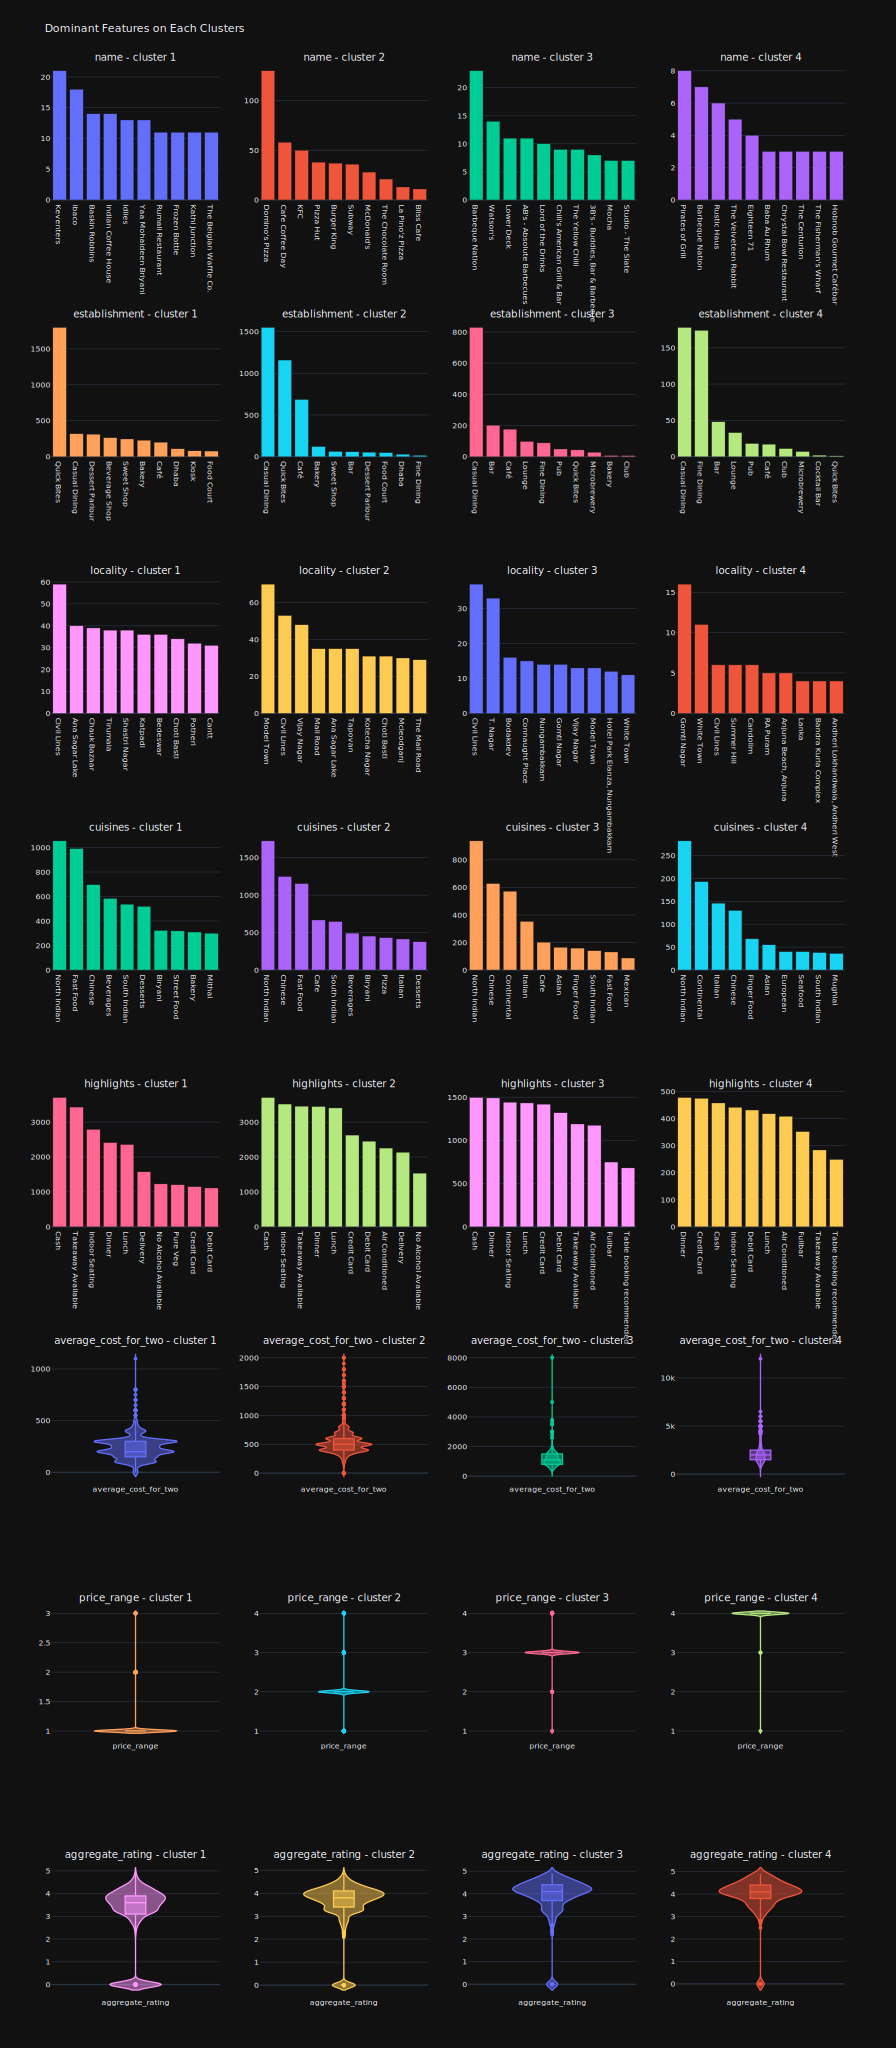

In [41]:
n_rows, n_cols = len(cols), clust_vals.n_unique()

fig = make_subplots(
    n_rows, n_cols,
    subplot_titles = [
        f'{col} - cluster {i + 1}' for col in cols for i in range(4)
    ]
)

def top_n_categories(col: pl.Series, top_k = 10):
    # Returns dataframe with 2 columns: value name and value count
    return col.value_counts().top_k(top_k, by = 'count')

for i, name in enumerate(cols):
    for j, clust in enumerate(clust_vals.sort().unique()):
        irow = i + 1
        icol = j + 1

        # Use the original dataframe instead of the transformed one
        col = df.filter(pl.col('cluster') == clust).get_column(name)
        top_k = 10

        if col.dtype in (pl.Int64, pl.Float64):
            fig.add_violin(y = col, box_visible = True, row = irow, col = icol, name = name)
        elif col.dtype in (pl.String, pl.Boolean):
            col = top_n_categories(col, top_k)
            fig.add_bar(x = col[name], y = col['count'], row = irow, col = icol, name = name)
        elif col.dtype == pl.List(pl.String):
            # "list.explode" will combine nested list as one long list
            col = top_n_categories(col.list.explode().drop_nans(), top_k)
            fig.add_bar(x = col[name], y = col['count'], row = irow, col = icol, name = name)

fig.update_layout(title = 'Dominant Features on Each Clusters', showlegend = False)
fig.show(width = 1400, height = 3200)

Seems like the clusters are heavily focused on price range, even though we already dropped that column before passing it to the model

This means the model knows what to do, though I'm a bit disappointed. I hoped to see a different result (that are not heavily focused on price range)

- Cluster 1
    - Price range is 1 (cheap)
    - Top restaurants: Keventers, ibaco, and Baskin Robbins
    - Locality (area) focused around Civil Lanes, Ana Sagar Lake, and Chauk Bazaar
    - Cuisines focused around Indian, fast food, Chinese, beverage, and desserts
    - Establishment focused around quick bites
    - Interesting highlights: cash, takeaway available, and delivery
- Cluster 2
    - Price range is 2 (mid)
    - Top restaurants: Domino's Pizza, Cafe Coffee Day, KFC, and Pizza Hut
    - Locality (area) focused around Model Town, Civil Lines, and Vijay Nagar
    - Cuisines focused around Indian, Chinese, fast food, and cafe
    - Establishment focused around casual dining, quick bites, and cafe
    - Interesting highlights: cash, takeaway available, and delivery
- Cluster 3
    - Price range is 3 (mid-high)
    - Top restaurants: Barbeque Nation, Watson's, and Absolute Barbeque
    - Locality (area) focused around Civil Lanes and T. Nagar
    - Cuisines focused around North Indian, Chinese, continental, and Italian
    - Establishment focused around casual dining, bar, and cafe
    - Interesting highlights: cash, dinner, full bar, and table booking
- Cluster 4
    - Price range is 4 (high)
    - Top restaurants: Pirates of Grill, Rustic House, and The Velveteen Rabbit
    - Locality (area) focused around Gomti Nagar and White Town
    - Cuisines focused around North Indian, continental, Italian, Chinese
    - Establishment focused around casual dining and fine dining
    - Interesting highlights: dinner, credit card, full bar, and table booking

In [42]:
# Check if cluster result is exactly the same as price range
# Homogeneity: each cluster contains only members of a single class
print(
    homogeneity_score(
        df.get_column('price_range'),
        df.get_column('cluster')
    )
)

print(
    confusion_matrix(
        df.get_column('price_range'),
        # Cluster index starts from 0
        df.get_column('cluster') + 1
    )
)

0.7555162882908983
[[3691  222    2    1]
 [ 156 3392   10    0]
 [   8  195 1452    3]
 [   0   25   74  485]]


Interesting, turns out the are still some differences between cluster result and price range

I suspect it's because inconsistencies between `average_cost_for_two` and `price_range`, but I'm leaving it as is

## 7. Export Dataset

In [43]:
df.drop('price_range').write_json('data/zomato_clustered.json')